# Training CNN model

## Import models, utility classes and functions

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mp

from Model import *
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('results/runs')

_n_neuron = 1

## Define the training procedure

In [2]:
def train_net(Train, LTrain, Test, LTest, lr, momentum, epoch=10, report=20, writer=writer):
    ntrain = 4900
    ntest = 100 
    imsize = np.array([144,256])
    nchannels = 1
    batchsize = 100
    size_resp = _n_neuron
    nsamples = ntrain
    
    net = LeNet(_n_neuron)
    net.cuda()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

    running_loss = 0.0
    test_scores = []
    train_scores = []
    training_loss = []
    batch_xs = torch.tensor(np.zeros((batchsize, nchannels, imsize[0], imsize[1])), device='cuda', dtype=torch.float32) #setup as [batchsize, width, height, numberOfChannels] and use np.zeros()
    batch_ys = torch.tensor(np.zeros((batchsize,size_resp)), device='cuda', dtype=torch.float32) #setup as [batchsize, the how many classes] 

    for e in range(epoch): #epoches 
        for i in range(int(nsamples/batchsize)): # try a small iteration size once it works then continue
            perm = np.arange(nsamples)
            np.random.shuffle(perm)
            for j in range(batchsize):
                batch_xs[j,:,:,:] = Train[perm[j],:,:,:]
                batch_ys[j,:] = LTrain[perm[j],:]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(batch_xs)
            loss = criterion(outputs, batch_ys) 
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
                            
            if (i+1) % report == 0:    # print every {report} iterations
                print('[%d, %5d] loss: %.3f' %
                        (e + 1, i + 1, running_loss / report))
                writer.add_scalar('training_loss', running_loss / report, e * nsamples + (i+1)*batchsize)
                training_loss += [running_loss / report]
                running_loss = 0.0

                train_accuracy = accuracy(net, batch_xs, batch_ys)
                train_scores += [train_accuracy]
                print('train_accuracy: %.3f' % train_accuracy)
                writer.add_scalar('training_accuracy', train_accuracy, e * nsamples + (i+1)*batchsize)

                test_accuracy = accuracy(net, Test, LTest)
                test_scores += [test_accuracy]
                print('test_accuracy: %.3f' % test_accuracy)
                writer.add_scalar('test_accuracy', test_accuracy, e * nsamples + (i+1)*batchsize)
                
                fig, axes = plt.subplots(4,8)
                for (weight,axe) in zip(net.conv1.weight, axes.ravel()):
                    axe.axis('off')
                    axe.imshow(weight.detach().squeeze().cpu().numpy())
                writer.add_figure('conv1_weight', fig, e * nsamples + (i+1)*batchsize)

                add_all(writer, net.conv1_act, 'conv1_activation', e * nsamples + (i+1)*batchsize)
                add_all(writer, net.conv2_act, 'conv2_activation', e * nsamples + (i+1)*batchsize)
    net.eval()
    return (net, test_scores, train_scores, training_loss)

## Import the dataset

In [3]:
Train, LTrain, Test, LTest = load_data(directory='data/')

## Train the CNN

In [4]:
%%time
net, test_scores, train_scores, training_loss = train_net(Train, LTrain, Test, LTest, lr=.1, momentum=0.9, epoch=30, report=20, writer=writer)

[1,    20] loss: 0.005
train_accuracy: 0.252
test_accuracy: 0.395
[1,    40] loss: 0.003
train_accuracy: 0.547
test_accuracy: 0.335
[2,    20] loss: 0.007
train_accuracy: 0.139
test_accuracy: 0.319
[2,    40] loss: 0.004
train_accuracy: 0.331
test_accuracy: 0.326
[3,    20] loss: 0.006
train_accuracy: 0.593
test_accuracy: 0.438
[3,    40] loss: 0.004
train_accuracy: 0.793
test_accuracy: 0.466
[4,    20] loss: 0.005
train_accuracy: 0.554
test_accuracy: 0.557
[4,    40] loss: 0.003
train_accuracy: 0.566
test_accuracy: 0.580
[5,    20] loss: 0.003
train_accuracy: 0.629
test_accuracy: 0.633
[5,    40] loss: 0.003
train_accuracy: 0.492
test_accuracy: 0.708
[6,    20] loss: 0.003
train_accuracy: 0.890
test_accuracy: 0.745
[6,    40] loss: 0.002
train_accuracy: 0.746
test_accuracy: 0.766
[7,    20] loss: 0.003
train_accuracy: 0.809
test_accuracy: 0.780
[7,    40] loss: 0.002
train_accuracy: 0.663
test_accuracy: 0.828
[8,    20] loss: 0.003
train_accuracy: 0.785
test_accuracy: 0.772
[8,    40]

## Train accuracy and test accuracy over iterations

In [17]:
iters = np.linspace(0,30*4900,len(test_scores))
plt.figure(dpi=300)
plt.plot(iters, test_scores, label='Test Accuracy')
plt.plot(iters, train_scores, label='Train Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Correlation')
plt.legend()

## Predicted complex cell responses to test set

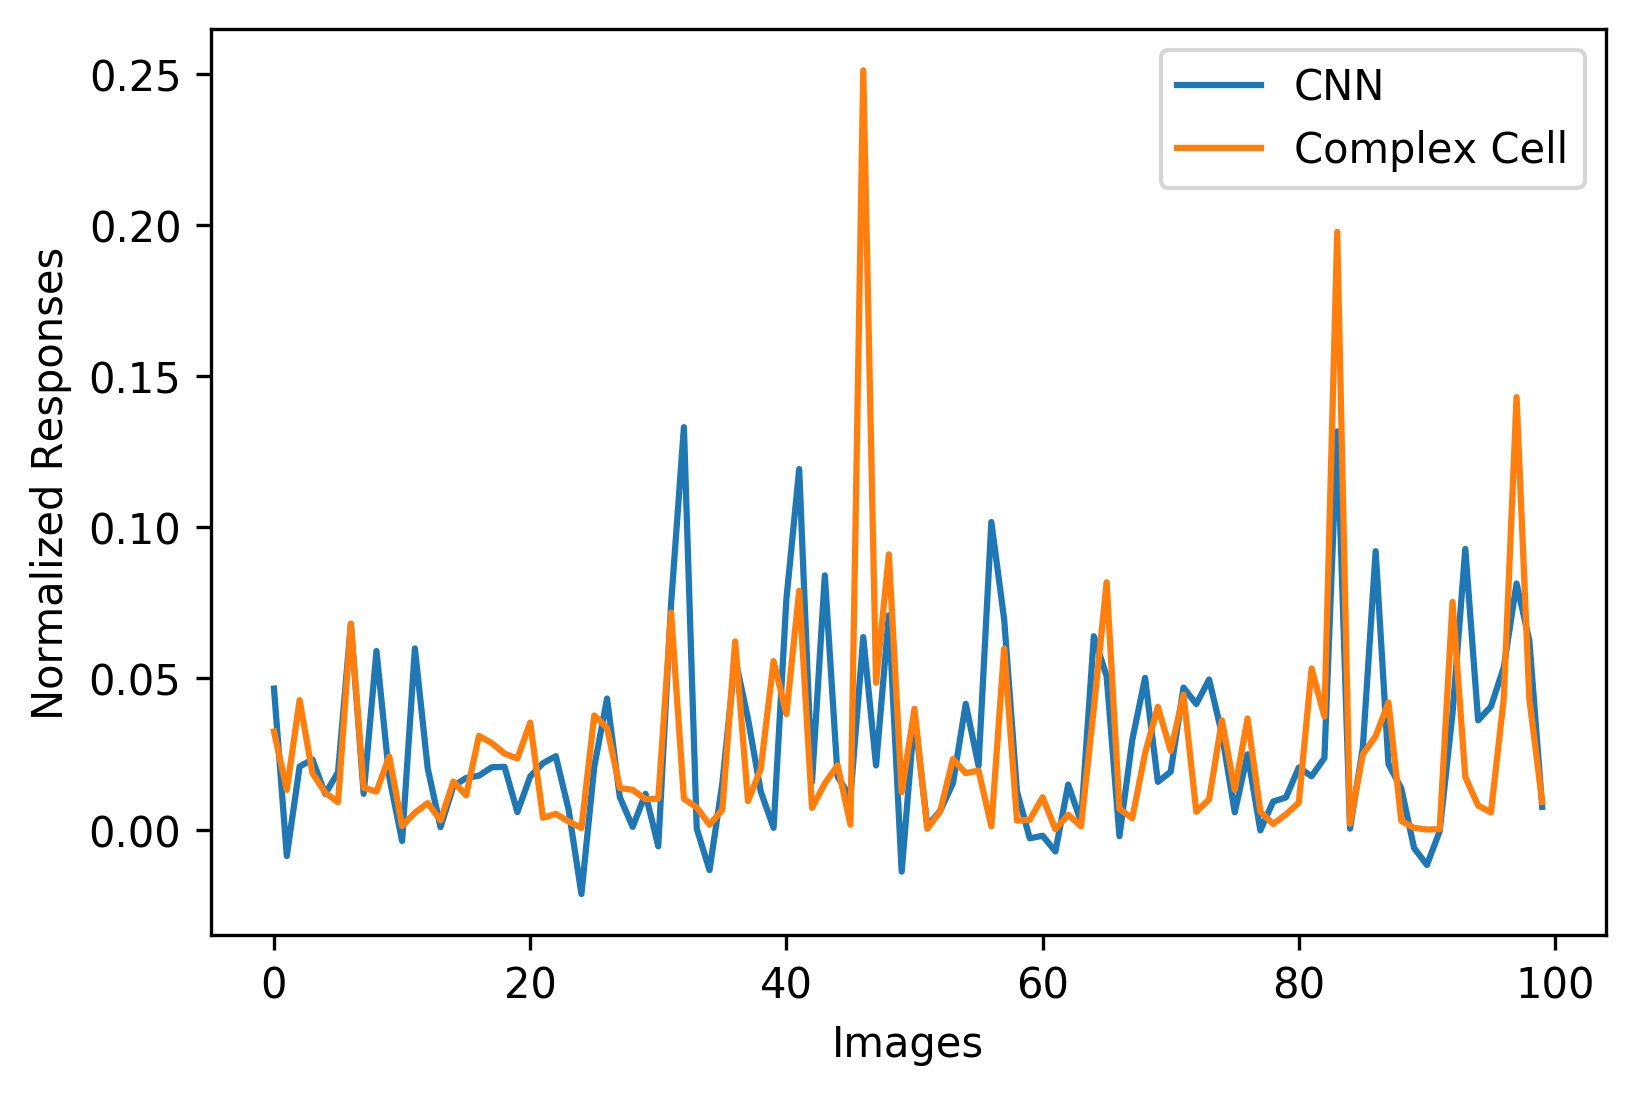

In [23]:
with torch.no_grad():
    ys = net(Test).cpu().numpy()

target = LTest.cpu().numpy()

plt.figure(dpi=300)
plt.plot(ys, label='CNN')
plt.plot(target, label='Complex Cell')
plt.xlabel('Images')
plt.ylabel('Normalized Responses')
plt.legend()

## Save the trained model

In [24]:
np.save('results/net',net)